In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import xarray as xr
import dask
print(f'dask: {dask.__version__}')
import dask.array
dask.config.set({'array.chunk-size': '512MiB'})

import extra_data as ed
import extra_geom as eg

import toolbox_scs as tb
import toolbox_scs.detectors as tbdet

tb.__file__

dask: 2022.11.0


'/home/lleguy/notebooks/ToolBox/src/toolbox_scs/__init__.py'

In [2]:
from dask.distributed import Client
client = Client(n_workers=20)
print(client)

<Client: 'tcp://127.0.0.1:38916' processes=20 threads=80, memory=754.39 GiB>


# Load binned data

In [3]:
proposal = 70003 #2719
runNB = 4 #224 #179
darkrunNB = 5 #225 #180
path = f'/gpfs/exfel/exp/XMPL/202350/p700003/usr/Shared/processed_runs/'

In [4]:
data = xr.open_mfdataset(path + f'r{runNB:04d}/*.h5', parallel=True, join='inner')

In [5]:
data

<xarray.Dataset>
Dimensions:            (module: 16, sa1_pId: 352, bin_delay: 226, pp: 2,
                        y: 128, x: 512, pulse_slot: 2700)
Coordinates:
  * module             (module) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * sa1_pId            (sa1_pId) int64 420 424 428 432 ... 1812 1816 1820 1824
  * bin_delay          (bin_delay) float64 223.8 223.8 223.9 ... 238.8 238.9
  * pp                 (pp) object 'pumped' 'unpumped'
Dimensions without coordinates: y, x, pulse_slot
Data variables:
    DSSC               (pp, bin_delay, module, y, x) float64 dask.array<chunksize=(2, 226, 1, 128, 512), meta=np.ndarray>
    PP800_DelayLine    (module, bin_delay) float64 dask.array<chunksize=(1, 226), meta=np.ndarray>
    bunchPatternTable  (module, bin_delay, pulse_slot) float64 dask.array<chunksize=(1, 226, 2700), meta=np.ndarray>
    SCS_SA1            (module, bin_delay, sa1_pId) float32 dask.array<chunksize=(1, 226, 352), meta=np.ndarray>
    SCS_SA3            (module, pp, bin_delay) float32 dask.array<chunksize=(1, 2, 226), meta=np.ndarray>
    BAM1932S           (module, bin_delay) float32 dask.array<chunksize=(1, 226), meta=np.ndarray>
    delay              (module, bin_delay) float64 dask.array<chunksize=(1, 226), meta=np.ndarray>

# Geometry

In [6]:
quad_pos = [(-122.81101449,    4.77217391),
           (-125.        , -118.24881159),
           (1.52336232, -119.89306931),
           (3.49344928,    2.90901765)]

#geopath = '/gpfs/exfel/exp/SCS/202002/p002719/scratch/Pre-processing/geometry/dssc_geom_AS_aug20.h5'
geopath = './dssc_geom_AS_aug20.h5'

geom = eg.DSSC_1MGeometry.from_h5_file_and_quad_positions(geopath, quad_pos)

# normalize scattering intensity by XGM
pumped_data = data['DSSC'].sel(pp='pumped')/data['SCS_SA3'].sel(pp='pumped', module=0)
unpumped_data = data['DSSC'].sel(pp='unpumped')/data['SCS_SA3'].sel(pp='unpumped', module=0)

# Check beam center with geom2

In [7]:
masklist = [
    (4, 1, 0),
    (1, 0, 6),
    (7, 1, 7), 
    (12, 1, 1),
    (5, 0, 3), 
    (14, 0, 4),
    (7, 1, 3),
    (6, 1, 3),
#    (7, 1, 1),
#    (7, 0, 1)
]
qmask = tbdet.quickmask_DSSC_ASIC(masklist)

In [8]:
img = qmask*(pumped_data.mean('bin_delay') - unpumped_data.mean('bin_delay')).values

vmin = np.nanpercentile(img.ravel(), 5)
vmax = np.nanpercentile(img.ravel(), 99.5)

(-0.045, 0.045)

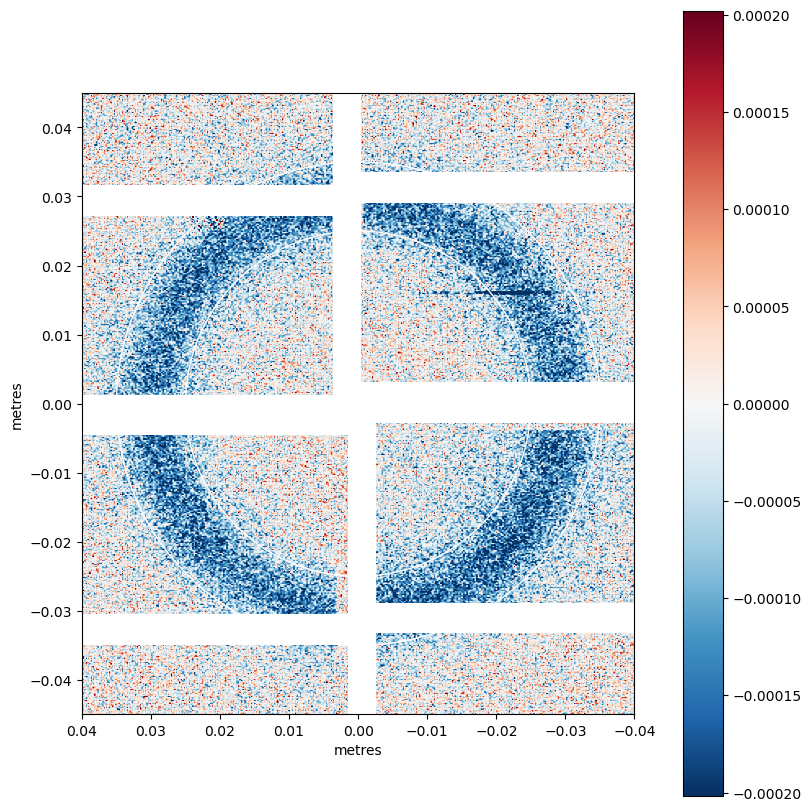

In [9]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

geom2 = geom.offset((0.000, -0.0019))

ax = geom2.plot_data(img,
                     colorbar=True, #norm=LogNorm(),
                     vmin=-vmax, vmax=vmax,
                     axis_units='m', figsize=(8,8),
                     cmap='RdBu_r')
ax.add_patch(Circle((0, 0), radius=0.025, fill=False, color='white'))
ax.add_patch(Circle((0, 0), radius=0.035, fill=False, color='white'))
ax.set_xlim([0.04, -0.04])
ax.set_ylim([-0.045, 0.045])

In [10]:
pumped_mean = qmask*pumped_data.mean('bin_delay')
unpumped_mean = qmask*unpumped_data.mean('bin_delay')

image_pumped_mean, _ = geom2.position_modules(pumped_mean)
image_unpumped_mean, _ = geom2.position_modules(unpumped_mean)

(-0.04, 0.04)

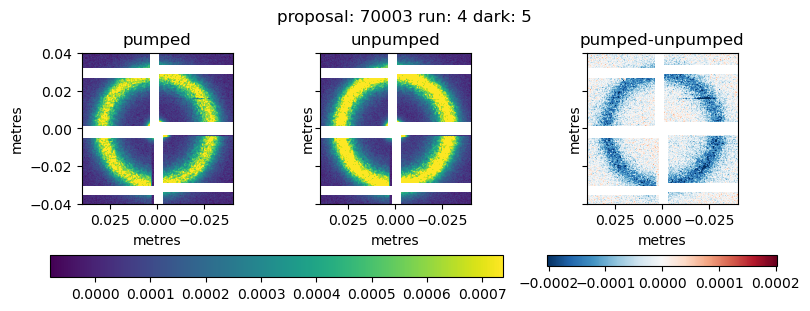

In [11]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8,3))
fig.suptitle(f'proposal: {proposal} run: {runNB} dark: {darkrunNB}')

cmap='viridis'
v1 = image_pumped_mean
vmin = np.nanpercentile(v1.ravel(), 5)
vmax = np.nanpercentile(v1.ravel(), 99.5)
im1 = geom2.plot_data(pumped_mean, ax=ax1,
           vmin=vmin, vmax=vmax, cmap=cmap,
                axis_units='m',
          aspect=1)
ax1.set_title('pumped')

v1 = image_unpumped_mean
im2 = geom2.plot_data(unpumped_mean, ax=ax2,
           vmin=vmin, vmax=vmax, cmap=cmap,
               axis_units='m')
fig.colorbar(im1.images[0], ax=[ax1, ax2], orientation='horizontal')
ax2.set_title('unpumped')

v1 = (image_pumped_mean - image_unpumped_mean)
vmin = np.nanpercentile(v1.ravel(), 5)
vmax = np.nanpercentile(v1.ravel(), 99.5)
im3 = geom2.plot_data(pumped_mean - unpumped_mean, ax=ax3,
           vmin=-vmax, vmax=vmax, cmap='RdBu_r',
            axis_units='m')
fig.colorbar(im3.images[0], ax=[ax3], orientation='horizontal')

ax3.set_title('pumped-unpumped')
ax3.set_xlim([0.04, -0.04])
ax3.set_ylim([-0.04, 0.04])

# Azimuthal integration

## Detector and x-ray settings

In [12]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

# Wavelength [m]
E = 852.4   # [eV]
c = 299792458   # [m/s]
h = 4.135667696e-15   # [eV-s]
wavelen = (h*c/E)  # [m]

# Detector position [m]
det_dis = 3.1

ai = AzimuthalIntegrator(detector=geom2.to_pyfai_detector(),
                        dist=det_dis,
                        wavelength=wavelen)

In [13]:
Npt = 900

def azint(data, dummy=False):
    
    rint_bbox, I_bbox = ai.integrate1d(
        data.reshape(16*128, 512),
        npt=Npt,
        unit='q_nm^-1',
        method='bbox'
    )
    
    if dummy:
        return rint_bbox, I_bbox
    else:
        return I_bbox

q, I = azint(np.zeros((16, 128, 512)), dummy=True)

In [14]:
az_pump = xr.apply_ufunc(azint, # the function to apply
                     qmask*pumped_data.chunk(('auto', -1, -1, -1)), # the data for the function, here only one
                     input_core_dims=[['module', 'y', 'x']], # dimension for each input arguments
                     output_core_dims=[['q']], # dimension for each output
                     #exclude_dims=set(('fit_v',)),  # dimensions allowed to change size. Must be set!
                     vectorize=True,
                     dask="parallelized",
                     output_dtypes=[q.dtype],
                     output_sizes={'q': q.shape[0]},
                    ).compute()

az_unpump = xr.apply_ufunc(azint, # the function to apply
                     qmask*unpumped_data.chunk(('auto', -1, -1, -1)), # the data for the function, here only one
                     input_core_dims=[['module', 'y', 'x']], # dimension for each input arguments
                     output_core_dims=[['q']], # dimension for each output
                     #exclude_dims=set(('fit_v',)),  # dimensions allowed to change size. Must be set!
                     vectorize=True,
                     dask="parallelized",
                     output_dtypes=[q.dtype],
                     output_sizes={'q': q.shape[0]},
                    ).compute()

In [15]:
t0 = 229.2
az_pump['q'] = q
az_pump['bin_delay'] = az_pump['bin_delay'] - t0
az_unpump['q'] = q
az_unpump['bin_delay'] = az_unpump['bin_delay'] - t0

Text(0.5, 1.0, 'proposal: 70003 run: 4 dark: 5')

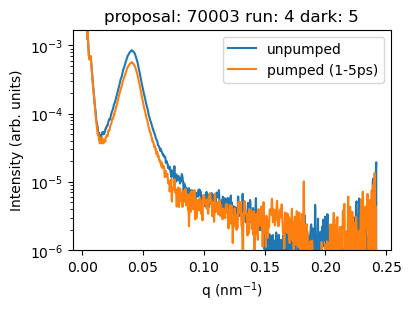

In [16]:
plt.figure(figsize=(4,3))
plt.plot(az_unpump['q'], az_unpump.mean('bin_delay'), label='unpumped')
plt.plot(az_pump['q'], az_pump.sel({'bin_delay': slice(1., 5.)}).mean('bin_delay'),
         label='pumped (1-5ps)')
plt.ylim([1e-6, None])
plt.semilogy()
plt.legend()
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('Intensity (arb. units)')
plt.title(f'proposal: {proposal} run: {runNB} dark: {darkrunNB}')

Text(0.5, 1.0, 'proposal: 70003 run: 4 dark: 5')

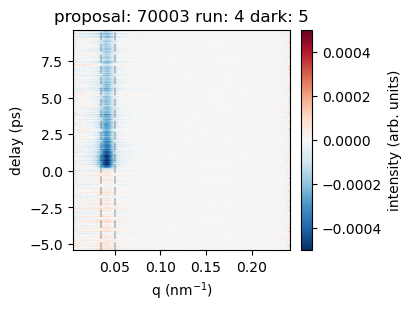

In [17]:
v = 0.0005
plt.figure(figsize=(4,3))
im = plt.pcolormesh(az_pump['q'], az_pump['bin_delay'],
                    az_pump-az_unpump,
                    vmin=-v, vmax=v, cmap='RdBu_r'
                   )
qlow = 0.035
qhigh = 0.05
plt.axvline(qlow, ls='--', c='k', alpha=0.2)
plt.axvline(qhigh, ls='--', c='k', alpha=0.2)

plt.colorbar(label='intensity (arb. units)')
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('delay (ps)')
plt.title(f'proposal: {proposal} run: {runNB} dark: {darkrunNB}')

In [18]:
pump_signal = az_pump.sel({'q': slice(qlow, qhigh)}).mean('q')
unpump_signal = az_unpump.sel({'q': slice(qlow, qhigh)}).mean('q')

pump_signal_pret0 = pump_signal.sel({'bin_delay': slice(-4, -2)}).mean('bin_delay')
unpump_signal_pret0 = unpump_signal.sel({'bin_delay': slice(-4, -2)}).mean('bin_delay')

Text(0.5, 1.0, 'proposal: 70003 run: 4 dark: 5')

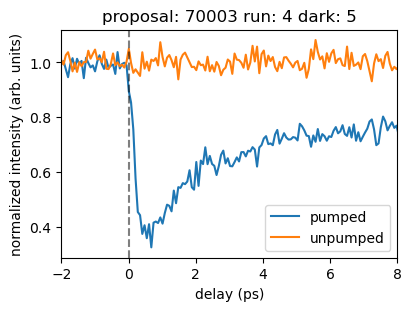

In [19]:
plt.figure(figsize=(4,3))
plt.plot(az_pump['bin_delay'], pump_signal/pump_signal_pret0, label='pumped')
plt.plot(az_unpump['bin_delay'], unpump_signal/unpump_signal_pret0, label='unpumped')
plt.legend()
plt.axvline(0, ls='--', c='k', alpha=0.5)
plt.xlabel('delay (ps)')
plt.ylabel('normalized intensity (arb. units)')
plt.title(f'Run {runNB}')
plt.xlim([-2, 8])
plt.title(f'proposal: {proposal} run: {runNB} dark: {darkrunNB}')